In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import itertools
import time
import sys

from kesi._verbose import (VerboseFFR,
                           LinearMixture,
                           LoadableVerboseFFR)
from kesi._engine import _LinearKernelSolver
sys.path.append('..')
import cbf
from FEM.fem_sphere_gaussian import (SomeSphereGaussianSourceFactory3D,
                                     SomeSphereGaussianSourceFactoryOnlyCSD)
from common import altitude_azimuth_mesh

MeasurementManagerBase = VerboseFFR.MeasurementManagerBase

Unable to import from dolfin


In [2]:
class MeasurementManager(MeasurementManagerBase):
    def __init__(self, ELECTRODES, space='potential'):
        self._space = space
        self._ELECTRODES = ELECTRODES
        self.number_of_measurements = len(ELECTRODES)
    def probe(self, field):
        return getattr(field, 
                       self._space)(self._ELECTRODES.X,
                                    self._ELECTRODES.Y,
                                    self._ELECTRODES.Z)

In [3]:
def all_sources(r, altitude, azimuth):
    return [factory(x, y, z)
            for x, y, z in itertools.product(r, altitude, azimuth)]

In [4]:
def calculate_point_error(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.

    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.

    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
                true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    point_error = err_r.reshape(true_csd.shape)
    return point_error

In [5]:
def calculate_rms(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rms: float
        Normalized error of reconstruction.
    """
    rms = np.linalg.norm((true_csd - est_csd))/(np.linalg.norm(true_csd))
    return rms

In [6]:
def calculate_rdm(true_csd, est_csd):
    """
    Calculates relative difference measure between reconstructed source and
    ground truth.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rdm: float
        Relative difference measure.
    """
    epsilon = np.finfo(np.float64).eps
    rdm = np.linalg.norm(est_csd/(np.linalg.norm(est_csd) + epsilon) -
                         true_csd/(np.linalg.norm(true_csd) + epsilon))
    return rdm

In [7]:
def calculate_rdm_point(true_csd, est_csd):
    rdm = abs(est_csd.reshape(est_csd.size, 1)/(np.linalg.norm(est_csd.reshape(est_csd.size, 1))) -
              true_csd.reshape(true_csd.size, 1)/(np.linalg.norm(true_csd.reshape(true_csd.size, 1))))
    rdm *= np.linalg.norm(true_csd.reshape(true_csd.size, 1))/np.max(abs(true_csd.reshape(true_csd.size, 1)))
    return rdm.reshape(true_csd.shape)

In [8]:
def calculate_mag(true_csd, est_csd):
    """
    Calculates magnitude ratio between reconstructed source and ground
    truth.
    Parameters
    ----------
    test_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    mag: float
        Magnitude ratio.
    """
    epsilon = np.finfo(np.float64).eps
    mag = np.linalg.norm(est_csd/(true_csd + epsilon))
    return mag

In [9]:
def calculate_mag_point(true_csd, est_csd):
    epsilon = np.max(abs(true_csd.reshape(true_csd.size, 1)))
    mag = abs(est_csd.reshape(est_csd.size, 1))/(abs(true_csd.reshape(true_csd.size, 1)) + epsilon)
    return mag.reshape(true_csd.shape)

In [10]:
def cross_validate(reconstructor, measurements, regularization_parameters):
    errors = np.zeros(regularization_parameters.size)
    for rp_idx, rp in enumerate(regularization_parameters):
        print('Cross validating regularization parameter :', rp)
        errors[rp_idx] = np.linalg.norm(reconstructor.leave_one_out_errors(measurements, rp))
    err_idx = np.where(errors == np.min(errors))
    cv_rp = regularization_parameters[err_idx][0]
    print('CV_rp :', cv_rp)
    return cv_rp, errors

In [11]:
def make_plot(values, val_type, X, Y, Z, path, idx=15, fig_title=None):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[:, :, idx], Z[:, :, idx], values[:, :, idx], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    ticks = np.linspace(t_min, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)
    return

In [12]:
def values_in_a_grid(X, values, IDX):
    VALUES = np.zeros(X.shape)  
    for v, i, j, k in zip(values, *np.where(IDX)):  # place values in regular grid
        VALUES[i, j, k] = v
    return VALUES

In [13]:
def generate_figure(X, Y, Z, values, values_type, IDX, layer, title, save_path=sys.path[0]):
    VALUES = values_in_a_grid(X, values, IDX)
    make_plot(VALUES, values_type, X, Y, Z, save_path, idx=layer, fig_title=title)

In [14]:
def make_subplot(ax, values, val_type, X, Y, Z, t_max, idx=15, fig_title=None, colorbar=False, cax=None):
    #plt.figure(figsize=(6, 6))
    #ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        #t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        #t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[idx, :, :], Z[idx, :, :], values[:, idx, :], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)', labelpad=0.04)
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    if colorbar:
        ticks = np.linspace(t_min, t_max, 3, endpoint=True)
        plt.colorbar(im, cax=cax, orientation='horizontal', format='%.0e', ticks=ticks)
    #plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)
    return

In [15]:
def generate_subplot(X, Y, Z, true_csd, est_csd1, type1, est_csd2, type2, IDX, layer, fig_title, src_nr=0, save_path=sys.path[0]):
    fig = plt.figure(figsize=(17, 15))
    csd_max = np.max(abs(true_csd[src_nr]))
    err_max = 0.6
    gs = gridspec.GridSpec(4, 3, height_ratios=[1., 1., 1., 0.04], left=0.135,
                           right=0.865, top=0.94, bottom=0.06)
    TRUE_CSD = values_in_a_grid(X, true_csd[src_nr], IDX)
    ax = plt.subplot(gs[0, 0])
    title = 'True csd'
    make_subplot(ax, TRUE_CSD, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    EST_CSD1 = values_in_a_grid(X, est_csd1[src_nr], IDX)
    ax = plt.subplot(gs[1, 0])
    title = 'Est csd ' + str(type1)
    make_subplot(ax, EST_CSD1, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    error1 = calculate_point_error(true_csd[src_nr], est_csd1[src_nr])
    ERROR1 = values_in_a_grid(X, error1, IDX)
    ax = plt.subplot(gs[1, 1])
    title = 'Error ' + str(type1)
    make_subplot(ax, ERROR1, 'err', X, Y, Z, err_max, idx=layer, fig_title=title)
    
    diff1 = (true_csd[src_nr] - est_csd1[src_nr])
    DIFF1 = values_in_a_grid(X, diff1, IDX)
    ax = plt.subplot(gs[1, 2])
    title = 'Diff ' + str(type1)
    make_subplot(ax, DIFF1, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    EST_CSD2 = values_in_a_grid(X, est_csd2[src_nr], IDX)
    ax = plt.subplot(gs[2, 0])
    cax = plt.subplot(gs[3, 0])
    title = 'Est csd ' + str(type2)
    make_subplot(ax, EST_CSD2, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    error2 = calculate_point_error(true_csd[src_nr], est_csd2[src_nr])
    ERROR2 = values_in_a_grid(X, error2, IDX)
    ax = plt.subplot(gs[2, 1])
    cax = plt.subplot(gs[3, 1])
    title = 'Error ' + str(type2)
    make_subplot(ax, ERROR2, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    diff2 = (true_csd[src_nr] - est_csd2[src_nr])
    DIFF2 = values_in_a_grid(X, diff2, IDX)
    ax = plt.subplot(gs[2, 2])
    cax = plt.subplot(gs[3, 2])
    title = 'Diff ' + str(type2)
    make_subplot(ax, DIFF2, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    fig_title = fig_title + ' validation ' + type1 + type2 + ' src_nr ' + str(src_nr)
    print(fig_title)
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)

In [16]:
def generate_reliability_maps(X, Y, Z, true_csd, est_csd, IDX, layer, fig_title, path):
    fig = plt.figure(figsize=(17, 6))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1., 0.04], width_ratios=[1]*3)
    error_kCSD_pts = np.array([calculate_point_error(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_kCSD = np.mean(error_kCSD_pts, axis=0)
    error_rdm_pts = np.array([calculate_rdm_point(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_rdm = np.mean(error_rdm_pts, axis=0)
    error_mag_pts = np.array([calculate_mag_point(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_mag = np.mean(error_mag_pts, axis=0)
    err_max = np.max(np.array([np.max(error_kCSD), np.max(error_rdm), np.max(error_mag)]))
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    ERROR_kCSD = values_in_a_grid(X, error_kCSD, IDX)
    title = 'Error kCSD'
    make_subplot(ax, ERROR_kCSD, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    ERROR_rdm = values_in_a_grid(X, error_rdm, IDX)
    title = 'Error rdm'
    make_subplot(ax, ERROR_rdm, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    ERROR_mag = values_in_a_grid(X, error_mag, IDX)
    title = 'Error mag'
    make_subplot(ax, ERROR_mag, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)
    return

In [17]:
def generate_eigensource_subplot(X, Y, Z, eigensources, IDX, layer, fig_title, path):
    #t_max = np.max(abs(eigensources))
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(6, 4, height_ratios=[1., 0.04, 1., 0.04, 1., 0.04], width_ratios=[1]*4)
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 0], IDX)
    title = 'Eigensource 1'
    t_max = np.max(abs(eigensources[:, 0]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 1], IDX)
    title = 'Eigensource 2'
    t_max = np.max(abs(eigensources[:, 1]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 2], IDX)
    title = 'Eigensource 3'
    t_max = np.max(abs(eigensources[:, 2]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 3])
    cax = plt.subplot(gs[1, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 3], IDX)
    title = 'Eigensource 4'
    t_max = np.max(abs(eigensources[:, 3]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 0])
    cax = plt.subplot(gs[3, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 4], IDX)
    title = 'Eigensource 5'
    t_max = np.max(abs(eigensources[:, 4]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 1])
    cax = plt.subplot(gs[3, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 5], IDX)
    title = 'Eigensource 6'
    t_max = np.max(abs(eigensources[:, 5]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 2])
    cax = plt.subplot(gs[3, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 6], IDX)
    title = 'Eigensource 7'
    t_max = np.max(abs(eigensources[:, 6]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 3])
    cax = plt.subplot(gs[3, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 7], IDX)
    title = 'Eigensource 8'
    t_max = np.max(abs(eigensources[:, 7]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 0])
    cax = plt.subplot(gs[5, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -4], IDX)
    title = 'Eigensource 252'
    t_max = np.max(abs(eigensources[:, -4]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 1])
    cax = plt.subplot(gs[5, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -3], IDX)
    title = 'Eigensource 253'
    t_max = np.max(abs(eigensources[:, -3]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 2])
    cax = plt.subplot(gs[5, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -2], IDX)
    title = 'Eigensource 254'
    t_max = np.max(abs(eigensources[:, -2]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 3])
    cax = plt.subplot(gs[5, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -1], IDX)
    title = 'Eigensource 255'
    t_max = np.max(abs(eigensources[:, -1]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)

In [18]:
def generate_projection_subplot(X, Y, Z, true_csd, est_csd, eigensources, projection, IDX, layer, fig_title, path):
    #t_max = np.max(abs(eigensources))
    fig = plt.figure(figsize=(17, 6))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1., 0.04], width_ratios=[1]*4)
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    TRUE_CSD = values_in_a_grid(X, true_csd, IDX)
    title = 'True CSD'
    t_max = np.max(abs(true_csd))
    make_subplot(ax, TRUE_CSD, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    EST_CSD = values_in_a_grid(X, est_csd, IDX)
    title = 'Est CSD'
    t_max = np.max(abs(est_csd))
    make_subplot(ax, EST_CSD, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    PROJECTION = values_in_a_grid(X, projection, IDX)
    title = 'CSD Projection on eigensources space'
    t_max = np.max(abs(projection))
    make_subplot(ax, PROJECTION, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 3])
    cax = plt.subplot(gs[1, 3])
    DIFF = values_in_a_grid(X, (true_csd-est_csd), IDX)
    title = 'Anihilator'
    t_max = np.max(abs(est_csd))
    make_subplot(ax, DIFF, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)

In [19]:
path = sys.path[0] + '/results/2020-05-21_13-46-05'

In [20]:
with np.load(path + '/Setup_info.npz', allow_pickle=True) as fh:
    meshname = fh['meshname']
    sources = fh['sources']
    ele_type = fh['ele_type']
    ELECTRODES = fh['ELECTRODES']
    X = fh['X']
    Y = fh['Y']
    Z = fh['Z']
    IDX = fh['IDX']
    EST_POINTS = fh['EST_POINTS']
    POTENTIAL = fh['POTENTIAL']
    TRUE_CSD = fh['TRUE_CSD']

In [21]:
with np.load(path + '/Estimation.npz', allow_pickle=True) as fh:
    EST_CSD_CV = fh['EST_CSD_CV']
    EST_CSD_0 = fh['EST_CSD_0']
    EST_CSD_LC = fh['EST_CSD_LC']
    REG_PARAMS = fh['REG_PARAMS']
    LAMBD_CV = fh['LAMBD']
    INDX_REG_PARAMS = fh['indx_rp']
    POTENTIAL_ERROR = fh['EE']
    LAMBD_LC = fh['L_LAMBD']
    LCURVE = fh['LCURVE']

In [22]:
with np.load(path + '/Spectral_decomposition.npz', allow_pickle=True) as fh:
    EIGENSOURCES = fh['EIGENSOURCES']
    EIGENVALUES = fh['EIGENVALUES']
    EIGENVECTORS = fh['EIGENVECTORS']
    PROJECTION = fh['PROJECTION']

In [23]:
ELECTRODES.shape

(64, 3)

In [24]:
sources[0].x
sources[0].y
sources[0].z

-0.0685

ECoG validation CVL-curve src_nr 0


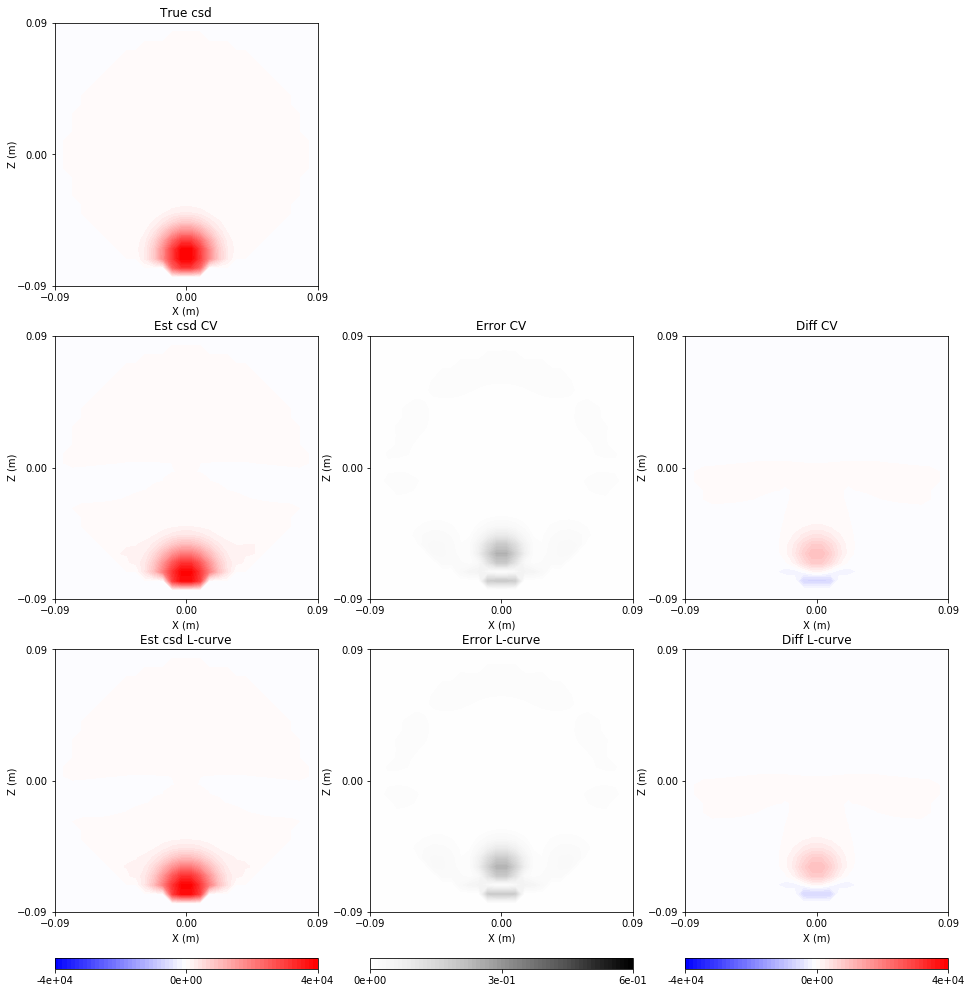

In [25]:
src_nr = 0
layer = 15
sphere = 'ECoG'
generate_subplot(X, Y, Z, TRUE_CSD, EST_CSD_CV, 'CV', EST_CSD_LC, 'L-curve', IDX, layer, str(sphere), src_nr, path)

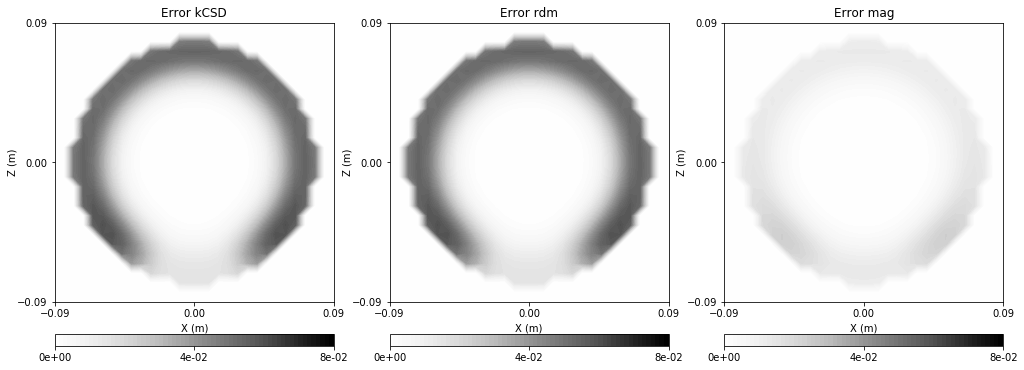

In [26]:
fig_title = str(sphere) + '_ReliabilityMaps_LC'
generate_reliability_maps(X, Y, Z, TRUE_CSD, EST_CSD_LC, IDX, layer, fig_title, path)

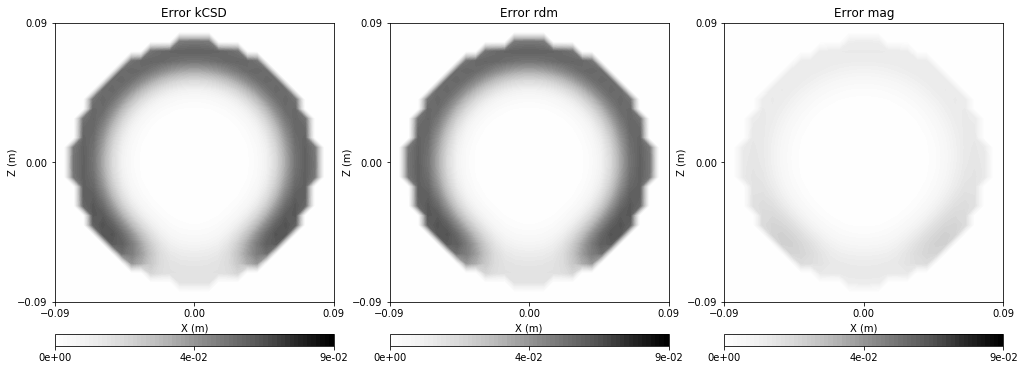

In [27]:
fig_title = str(sphere) + '_ReliabilityMaps_CV'
generate_reliability_maps(X, Y, Z, TRUE_CSD, EST_CSD_CV, IDX, layer, fig_title, path)

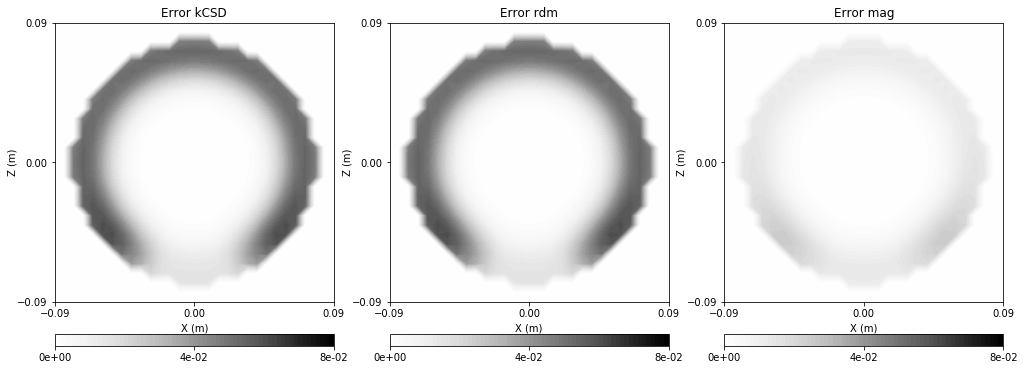

In [28]:
fig_title = str(sphere) + '_ReliabilityMaps_RP0'
generate_reliability_maps(X, Y, Z, TRUE_CSD, EST_CSD_0, IDX, layer, fig_title, path)

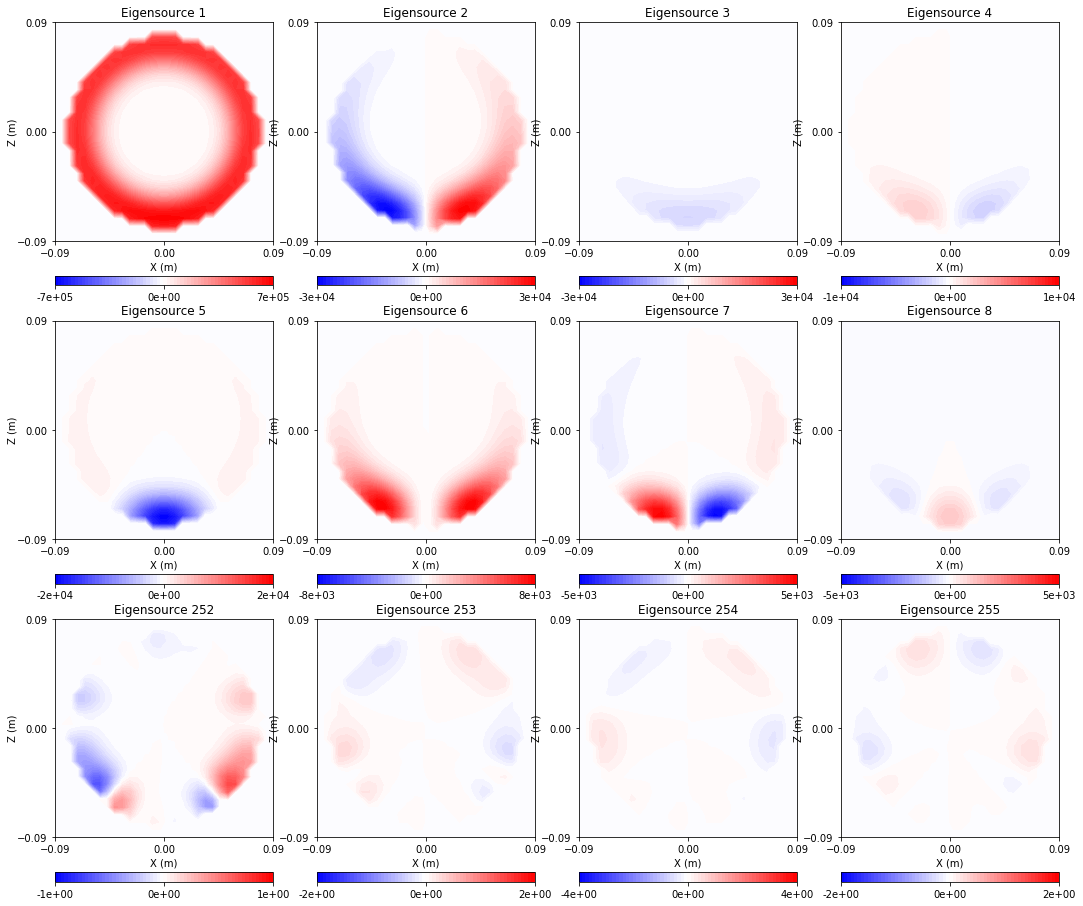

In [30]:
generate_eigensource_subplot(X, Y, Z, EIGENSOURCES, IDX, layer, str(sphere)+'_Eigensources_different_scales', path)

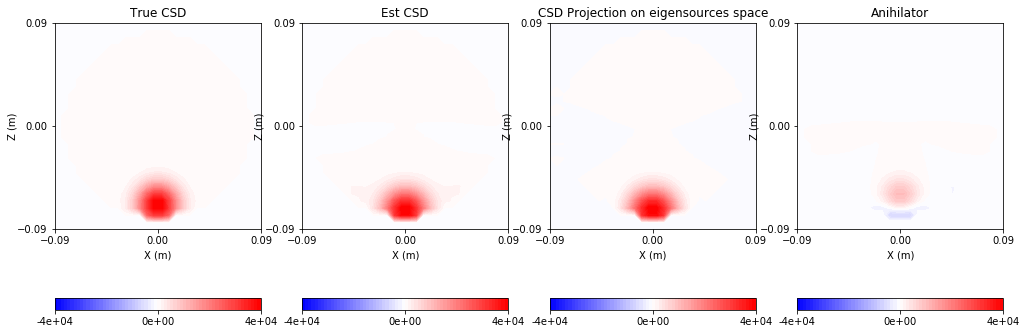

In [31]:
generate_projection_subplot(X, Y, Z, TRUE_CSD[src_nr], EST_CSD_CV[src_nr], EIGENSOURCES, PROJECTION[src_nr], IDX, layer, str(sphere)+'_Projection', path)

In [32]:
def picard_plot_log(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, save_path):
    #idx = eigenvalues.argsort()[::-1]
    #eigenvalues = eigenvalues[idx]
    #eigenvectors = eigenvectors[:, idx]
    #eigenvalues = np.sqrt(eigenvalues)
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    #plt.figure(figsize=(8, 5))
    ax.set_title('Picard plot')
    ax.plot(eigenvalues, eigenvalues, '.', color=cbf.BLUE, label=r'$\mu^{\frac{1}{2}}$')
    ax.plot(eigenvalues, utb, color=cbf.ORANGE, label='$|W^{T}V|$')
    ax.plot(eigenvalues, utbs, color=cbf.GREEN, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    #plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    ax.set_yscale('log')
    ax.set_xlabel('Eigenvalues')
    ax.set_xscale('log')
    ax.invert_xaxis()
    ax.legend(ncol=4)
    #plt.savefig(save_path +'/figs/Picard_plot_log '+str(sphere)+' 1000_pots_' + str(src_nr) + '.png', dpi=300)
    #plt.show()

In [34]:
def plot_cv_errors(ax, rps, rp_errors, sphere, src_nr, save_path):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere)
    ax.plot(rp_errors, '.', color=cbf.BLACK)
    #ax.plot(rps, rp_errors, '.')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Component number')
    ax.set_ylabel('Error in potential space')
    #ax.invert_xaxis()
    #plt.savefig(save_path + '/figs/cv_errors ' + sphere + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [35]:
def plot_errors_vs_components(ax, rps, rp_errors, rms, rdm, sphere, src_nr, save_path):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere)
    ax2 = ax.twinx()
    ax.plot(rp_errors, '.', color=cbf.BLACK, label='POTS ERROR')
    ax2.plot(rms, '.', color=cbf.VERMILION, label='RMS')
    ax2.plot(rdm, '.', color=cbf.SKY_BLUE, label='RDM')
    #ax.plot(rps, rp_errors, '.')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax2.set_ylim(bottom=0)
    ax.set_xlabel('Component number')
    ax.set_ylabel('Error in potential space')
    #ax2.set_ylabel('Error in csd space')
    ax2.tick_params(direction="in")
    ax2.yaxis.set_ticklabels([])
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc=1)
    #ax.invert_xaxis()
    #plt.savefig(save_path + '/figs/cv_errors ' + sphere + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [36]:
rms = np.zeros(len(EIGENVALUES))
rdm = np.zeros(len(EIGENVALUES))
mag = np.zeros(len(EIGENVALUES))
for j, value in enumerate(EIGENVALUES):
    est_csd_ev = cross_reconstructor(POTENTIAL[src_nr], np.array(value))
    rms[j] = calculate_rms(TRUE_CSD[src_nr], est_csd_ev)
    rdm[j] = calculate_rdm(TRUE_CSD[src_nr], est_csd_ev)
    mag[j] = calculate_mag(TRUE_CSD[src_nr], est_csd_ev)

NameError: name 'cross_reconstructor' is not defined

In [37]:
with np.load(path + '/GlobalErrors.npz', allow_pickle=True) as fh:
    rms = fh['RMS']
    rdm = fh['RDM']
    mag = fh['MAG']

In [38]:
def plot_global_csd_errors(ax, rps, rms, rdm, mag, sphere, src_nr, save_path, title):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere + title)
    ax.plot(rps, rms, '.', color=cbf.VERMILION, label='RMS')
    ax.plot(rps, rdm, '.', color=cbf.SKY_BLUE, label='RDM')
    #ax.plot(rps, mag, '.', label='RMAG')
    ax.set_ylim(bottom=0)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel('Regularization parameter')
    ax.set_ylabel('Error in csd space')
    ax.invert_xaxis()
    ax.legend()
    #plt.savefig(save_path + '/figs/' + sphere + title + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [39]:
def plot_errors_vs_parameters(ax, rps, rp_errors, rms, rdm, rp, sphere, src_nr, save_path, title):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere + title)
    x = rps[np.where(rps>0)]
    ax.plot(rps[np.where(rps>0)], rms, '.', color=cbf.VERMILION, label='RMS')
    ax.plot(rps[np.where(rps>0)], rdm, '.', color=cbf.SKY_BLUE, label='RDM')
    ax.axvline(x=rp, linestyle='--', color=cbf.PURPLE, label='CV')
    ax.axvline(x=x[np.where(rms==np.min(rms))], linestyle='-.', color=cbf.YELLOW, label='min rms')
    ax2 = ax.twinx()
    ax2.plot(rps[np.where(rps>0)], rp_errors, '.', color=cbf.BLACK, label='POTS ERROR')
    ax.set_ylim(bottom=0)
    ax.set_xscale('log')
    #ax2.set_yscale('log')
    ax.set_xlabel('Regularization parameter')
    ax.set_ylabel('Error in csd space')
    #ax2.set_ylabel('Error in potential space')
    ax.tick_params(direction="in")
    ax.invert_xaxis()
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h2+h1, l2+l1, loc=1)
    #plt.savefig(save_path + '/figs/' + sphere + title + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [40]:
def picard_plot(ax, eigenvalues, eigenvectors, potential, sphere, number, save_path):
    #idx = eigenvalues.argsort()[::-1]
    #eigenvalues = eigenvalues[idx]
    #eigenvectors = eigenvectors[:, idx]
    #eigenvalues = np.sqrt(eigenvalues)
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    ax.set_title('Picard plot')
    ax.plot(eigenvalues, '.', color=cbf.BLUE, label=r'$\mu^{\frac{1}{2}}$')
    ax.plot(utb, color=cbf.ORANGE, label='$|W^{T}V|$')
    ax.plot(utbs, color=cbf.GREEN, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    #plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    ax.set_yscale('log')
    ax.set_xlabel('Component number')
    #ax.invert_xaxis()
    #ax.set_xlim(ax.get_xlim()[::-1])
    ax.legend(ncol=4)
    #plt.savefig(save_path +'/Picard_plot '+str(sphere)+' 1000_pots_' + str(number) + '.png', dpi=300)
    #plt.show()

In [41]:
from mpl_toolkits.mplot3d import Axes3D
def plot_electrodes(ax, ELE_X, ELE_Y, ELE_Z, src_x, src_y, src_z, label='EEG'):
    ax.scatter(ELE_X, ELE_Y, ELE_Z, label=label)
    ax.set_title('Electrodes')
    #ax.scatter(point[:,0], point[:,1], point[:,2], label='ECoG')
    ax.scatter(src_x, src_y, src_z, 'r', s=25)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.set_xticks([ELE_X.min(), 0, ELE_X.max()])
    ax.set_yticks([ELE_Y.min(), 0, ELE_Y.max()])
    ax.set_zticks([ELE_Z.min(), 0, ELE_Z.max()])


In [44]:
def generate_Picard_subplot(eigenvalues, eigenvectors, true_csd, potential,
                            cv_errors, rms, rdm, mag, rp, sphere, src_nr, path,
                            ELE_X, ELE_Y, ELE_Z, src_x, src_y, src_z, X):
    plt.figure(figsize=(12, 8))
    
    ax = plt.subplot(231)
    picard_plot(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, path)
    
    ax = plt.subplot(232)
    picard_plot_log(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, path)
    
    ax = plt.subplot(233)
    TRUE_CSD = values_in_a_grid(X, true_csd, IDX)
    title = 'True CSD'
    t_max = np.max(abs(true_csd))
    make_subplot(ax, TRUE_CSD, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=False)
    
    ax = plt.subplot(234)
    plot_errors_vs_components(ax, eigenvalues, cv_errors, rms, rdm, sphere, src_nr, path)
    
    ax = plt.subplot(235)
    plot_errors_vs_parameters(ax, eigenvalues, cv_errors, rms, rdm, rp, sphere, src_nr, path, ' ')
    
    ax = plt.subplot(236, projection='3d')
    plot_electrodes(ax, ELE_X, ELE_Y, ELE_Z, src_x, src_y, src_z)
    
    #ax = plt.subplot(224)
    #plot_global_csd_errors(ax, eigenvalues, rms, rdm, mag, sphere, src_nr, path, ' ')
    
    plt.savefig(path +'/Picard_diagnostics_ '+str(sphere)+' 1000_pots_' + str(src_nr) + '.png', dpi=300)

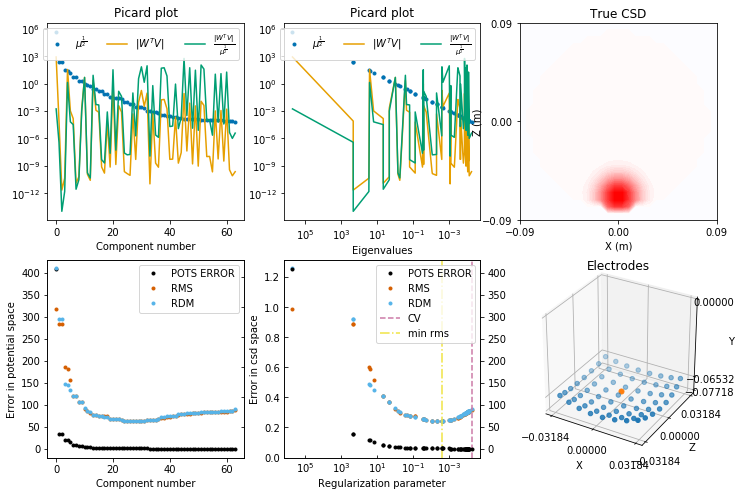

In [43]:
generate_Picard_subplot(EIGENVALUES, EIGENVECTORS, TRUE_CSD[src_nr], POTENTIAL[src_nr],
                        POTENTIAL_ERROR[:, src_nr], rms, rdm, mag, LAMBD_CV, sphere, src_nr, path,
                        ELECTRODES[:, 0], ELECTRODES[:, 1], ELECTRODES[:, 2], sources[0].x, sources[0].y, sources[0].z, X)

In [ ]:
p_eigenvalues = eigenvalues[np.where(eigenvalues > 0)]
p_eigenvectors = eigenvectors[:, np.where(eigenvalues > 0)]

In [ ]:
for i in range(len(potential))[0::500]:
    rp, cv_errors = cross_validate(cross_reconstructor, potential[i], p_eigenvalues)
    rms = np.zeros(len(p_eigenvalues))
    rdm = np.zeros(len(p_eigenvalues))
    mag = np.zeros(len(p_eigenvalues))
    for j, value in enumerate(p_eigenvalues):
        est_csd_ev = cross_reconstructor(potential[i], np.array(value))
        rms[j] = calculate_rms(true_csd[i], est_csd_ev)
        rdm[j] = calculate_rdm(true_csd[i], est_csd_ev)
        mag[j] = calculate_mag(true_csd[i], est_csd_ev)
    generate_Picard_subplot(eigenvalues, eigenvectors, true_csd[i], potential[i],
                            cv_errors, rms, rdm, mag, rp, sphere, i, path,
                            ELE_X, ELE_Y, ELE_Z, src_x, src_y, src_z)

In [ ]:
src_nr = 0
EIGENVALUES = eigen_parameters
rms = np.zeros(len(EIGENVALUES))
rdm = np.zeros(len(EIGENVALUES))
mag = np.zeros(len(EIGENVALUES))
for j, value in enumerate(EIGENVALUES):
    est_csd_ev = cross_reconstructor(potential[src_nr], np.array(value))
    rms[j] = calculate_rms(true_csd[src_nr], est_csd_ev)
    rdm[j] = calculate_rdm(true_csd[src_nr], est_csd_ev)
    mag[j] = calculate_mag(true_csd[src_nr], est_csd_ev)
np.savez_compressed(save_path + '/GlobalErrors.npz', RMS=rms, RDM=rdm, MAG=mag)